In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [2]:
plt.style.use('seaborn-bright')

In [3]:
data = pd.read_pickle('data.csv')
print(data.shape)
data.head(2)

(12158, 12)


,model,name,url,drive,color,price,year,mileage,city,eng_vol,hp,fuel
0,camry,VIII (XV70),https://auto.ru/cars/used/sale/toyota/camry/11...,передний,чёрный,3599000,2020,46000,Санкт-Петербург,3.5,249,Бензин
1,camry,VII (XV50) Рестайлинг,https://auto.ru/cars/used/sale/toyota/camry/11...,передний,белый,1660000,2016,123000,Екатеринбург,2.0,150,Бензин


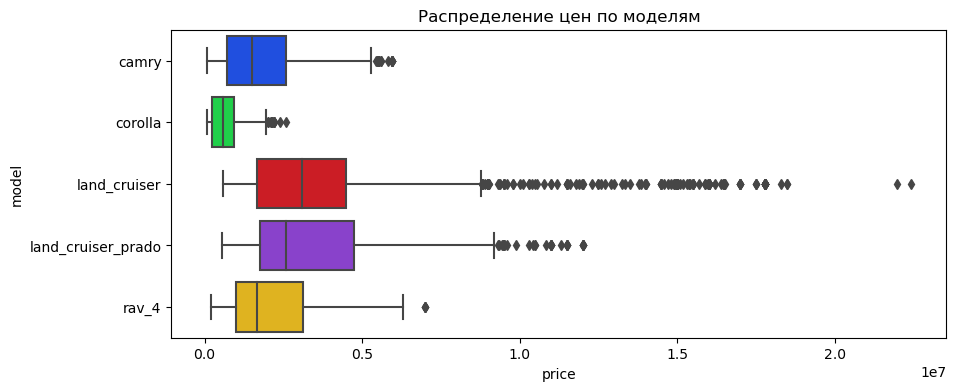

In [4]:
_, ax = plt.subplots(figsize=(10, 4))
ax = sns.boxplot(data=data, y='model', x='price', orient='h')
ax.set_title('Распределение цен по моделям')
plt.show()

#### Видны аномальные значения в верхних границах. Удалим записи со значениями цены выше 1.5*IQR для каждой модели.

In [5]:
def drop_by_IQR(series):
    q = [25, 75]
    perc = np.percentile(series, q)
    iqr = perc[1] - perc[0]
    u_bound = perc[1] + 1.5*iqr
    return series[series > perc[1]].index.tolist()

In [6]:
outliers = []
for model in data.model.cat.categories:
    outls = drop_by_IQR(data[data['model'] == model]['price'])
    outliers += outls

data = data.drop(outliers)
del outls, outliers

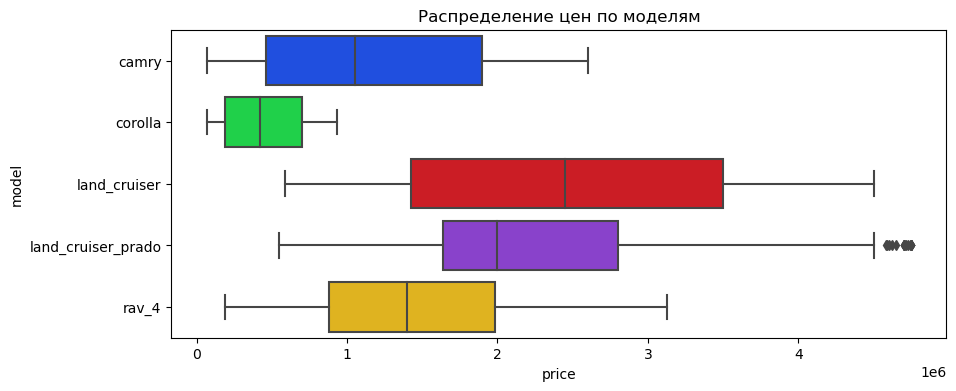

In [7]:
_, ax = plt.subplots(figsize=(10, 4))
ax = sns.boxplot(data=data, y='model', x='price', orient='h')
ax.set_title('Распределение цен по моделям')
plt.show()

In [8]:
def plot_mi_corr_scores(X, y):
    mi_scores = mutual_info_classif(X=X, y=y)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns).sort_index()
    corr_scores = X.corrwith(y).sort_index()
    
    _, (ax0, ax1) = plt.subplots(1,2,figsize=(12, 3))
    sns.barplot(y=mi_scores.index, x=mi_scores.values, ax=ax0, orient='h', color='orange')
    sns.barplot(y=corr_scores.index, x=corr_scores.abs().values, ax=ax1, orient='h', color='coral')
    ax0.set_title('MI scores')
    ax1.set_title('Corr scores')
    plt.show()
    
    return mi_scores, corr_scores

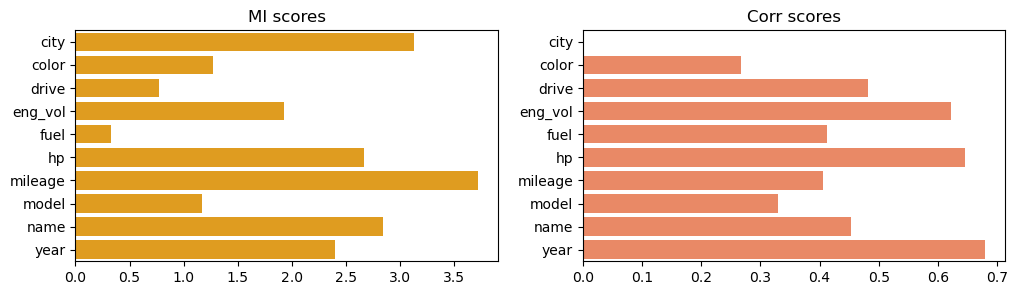

In [9]:
df = data.copy()
for cat_col in df.select_dtypes('category').columns:
    df[cat_col] = df[cat_col].cat.codes

X = df.drop('url', axis=1).copy()
y = X.pop('price')
mi_scores, corr_scores = plot_mi_corr_scores(X, y)

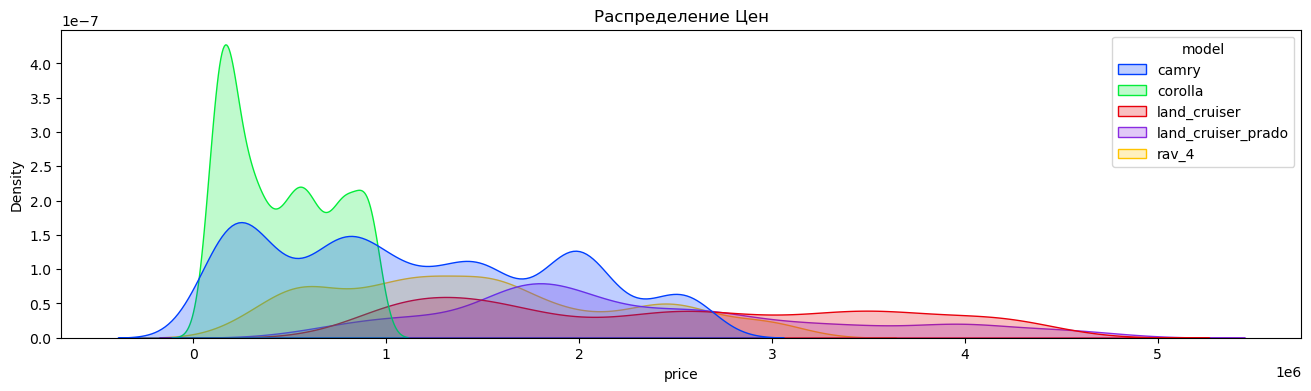

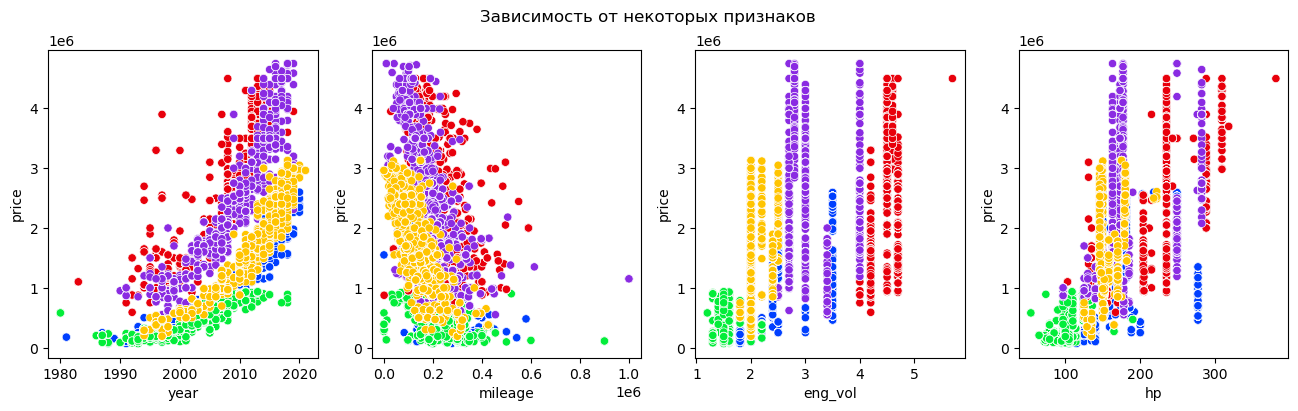

In [10]:
discr_features = ['year', 'mileage', 'eng_vol', 'hp']

_, ax = plt.subplots(figsize=(16,4))
sns.kdeplot(x=data['price'], hue=data['model'], ax=ax, shade=True)
ax.set_title('Распределение Цен')
    

fig, ax = plt.subplots(1, 4, figsize=(16,4))
ax = ax.ravel()
for i, col in enumerate(discr_features):
    sns.scatterplot(data=data, x=col, y='price', hue='model', ax=ax[i])
    ax[i].legend().remove()
fig.suptitle('Зависимость от некоторых признаков')

plt.show()

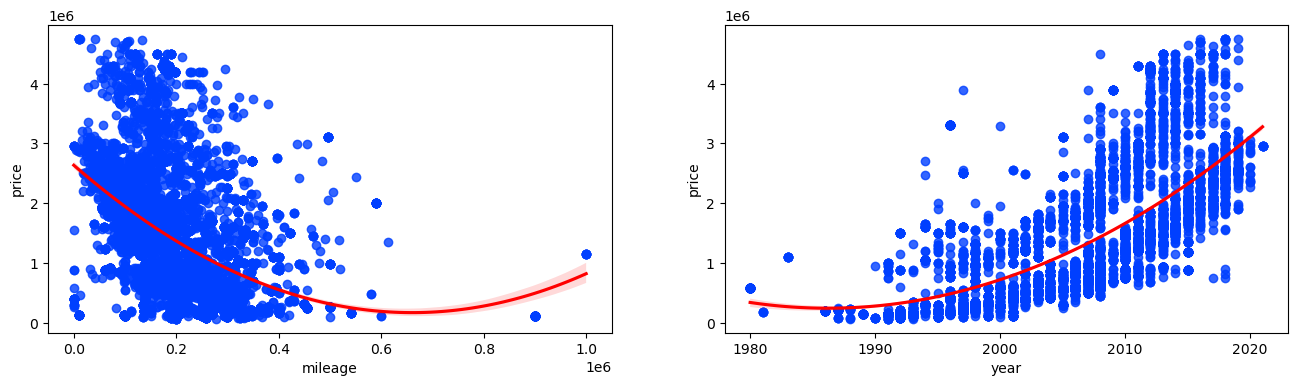

In [11]:
_, ax = plt.subplots(1,2,figsize=(16,4))
sns.regplot(x=data.mileage, y=data.price, order=2, line_kws={"color": "red"}, ax=ax[0])
sns.regplot(x=data.year, y=data.price, order=2, line_kws={"color": "red"}, ax=ax[1])
plt.show()

1. большинство цен - до ~2.5 млн
2. похоже, что связь между 'price' и 'year','mileage' - нелинейная, добавим квадрат этих признаков
3. можно отдельно посмотреть на распределение цен по eng_vol

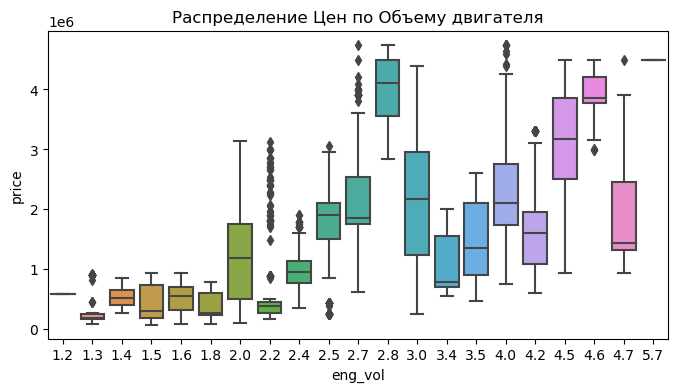

In [12]:
_, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data=data, x='eng_vol', y='price', orient='v', ax=ax)
ax.set_title('Распределение Цен по Объему двигателя')
plt.show()

#### Попробуем сгруппировать схожие по распределению eng_vol

In [13]:
eng_vol_groups = [
    [1.2, 1.3, 1.4, 1.5, 1.6, 1.8, 2.2, 2.4],
    [2.0, 2.5, 2.7, 3.0, 3.5, 4.0, 4.2, 4.7],
    [2.8, 4.5, 4.6],
    [3.4],
    [5.7]
]

data['eng_gr'] = (data.eng_vol
                      .apply(lambda eng: np.where([eng in eng_vols for
                                                   eng_vols in eng_vol_groups])[0][0]))
# Отсортируем метки по возрастанию медианы объема двигателя
eng_grs = data.groupby('eng_gr')['eng_vol'].median()
eng_grs.sort_values(inplace=True)
eng_map = dict(zip(
    eng_grs.index,
    range(len(eng_grs))
))
data['eng_gr'] = data['eng_gr'].map(eng_map)
print('Медиана eng_vol каждой группе "eng_gr":')
data.groupby('eng_gr')['eng_vol'].median()

Медиана eng_vol каждой группе "eng_gr":


eng_gr
0    1.6
1    2.5
2    3.4
3    4.5
4    5.7
Name: eng_vol, dtype: float64

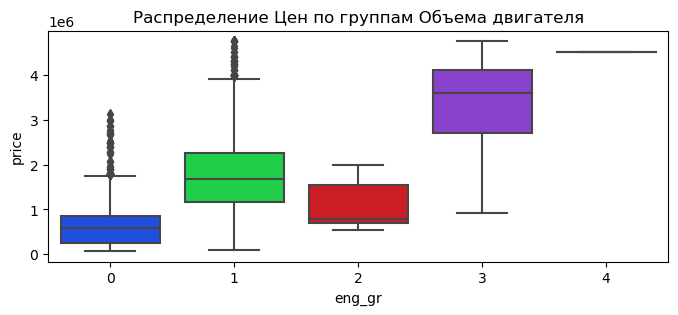

In [14]:
_, ax = plt.subplots(figsize=(8, 3))
sns.boxplot(data=data, x='eng_gr', y='price', ax=ax)
ax.set_title('Распределение Цен по группам Объема двигателя')
plt.show()

#### Сгруппируем города по кол-ву объявлений

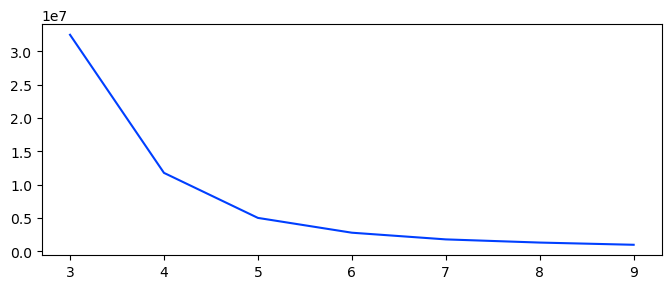

In [15]:
clus_nums = np.arange(3,10)
distances = []
data['city_ad_cnt'] = data.groupby('city')['price'].transform('count')

for clus_num in clus_nums:
    kmeans = KMeans(clus_num)
    kmeans.fit(data[['city_ad_cnt']])
    distances.append(kmeans.inertia_)

_, ax = plt.subplots(figsize=(8, 3))
plt.plot(clus_nums, distances)
plt.show()

In [16]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters)
data['city_gr'] = kmeans.fit_predict(data[['city_ad_cnt']])

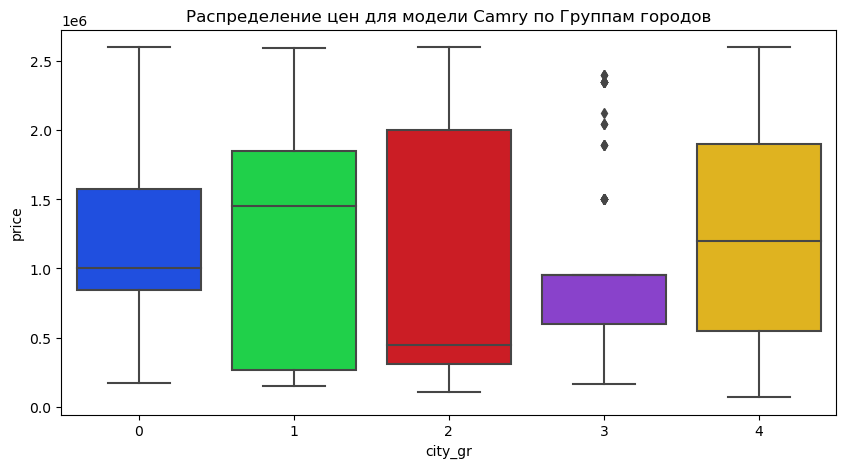

Среднее кол-во объявлений в каждой группе
0: 451.0
1: 153.0
2: 250.0
3: 664.0
4: 35.0


In [17]:
cty_gr_cnt = [f'{tup[0]}: {tup[1]}' for tup in
              list(zip(range(n_clusters), [data[data['city_gr'] == gr]['city_ad_cnt'].median()
                                           for gr in range(n_clusters)]))]
_, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=data[data['model'] == 'camry'], x='city_gr', y='price', ax=ax)
ax.set_title('Распределение цен для модели Camry по Группам городов')
plt.show()
print('Среднее кол-во объявлений в каждой группе')
print('\n'.join(cty_gr_cnt))

In [18]:
del data['city_ad_cnt']

In [19]:
data.to_pickle('data_eda.csv')